In [24]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from tqdm import tqdm

In [3]:
ds_cfd = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_cfd.nc")
ds_fd = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_fd.nc")
ds_csu = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_csu.nc")
ds_id = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_id.nc")
ds_su = xr.open_dataset("/data-uerra/mescan-surfex/temperature/mescan-surfex-nordics-eca_su.nc")

ds_cdd = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_cdd.nc")
ds_cwd = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_cwd.nc")
ds_pd = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_pd.nc")
ds_rr1 = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_rr1.nc")
ds_rx1day = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_rx1day.nc")
ds_rx5day = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_rx5day.nc")
ds_sdii = xr.open_dataset("/data-uerra/mescan-surfex/precipitation/mescan-surfex-nordics-eca_sdii.nc")

In [4]:
lons, lats = np.meshgrid(ds_cfd.lon, ds_cfd.lat)

In [5]:
ds_spruce = xr.open_dataset('../../data/finland/mescan_surfex_spruce_ratio_finland.nc')

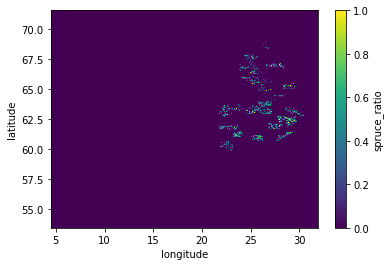

In [6]:
ds_spruce.spruce_ratio.plot()

In [7]:
data = {
    'ratio': ds_spruce.spruce_ratio.values.ravel()
}

In [8]:
data["cfd"] = ds_cfd.number_of_cfd_periods_with_more_than_5days_per_time_period.values.ravel()
data["fd"] = ds_fd.frost_days_index_per_time_period.values.ravel()
data["csu"] = ds_csu.number_of_csu_periods_with_more_than_5days_per_time_period.values.ravel()
data["id"] = ds_id.ice_days_index_per_time_period.values.ravel()
data["su"] = ds_su.summer_days_index_per_time_period.values.ravel()

In [9]:
data["cdd"] = ds_cdd.number_of_cdd_periods_with_more_than_5days_per_time_period.values.ravel()
data["cwd"] = ds_cwd.number_of_cwd_periods_with_more_than_5days_per_time_period.values.ravel()
data["pd"] = ds_pd.precipitation_days_index_per_time_period.values.ravel()
data["rr1"] = ds_rr1.wet_days_index_per_time_period.values.ravel()
data["rx1day"] = ds_rx1day.highest_one_day_precipitation_amount_per_time_period.values.ravel()
data["rx5day"] = ds_rx5day.highest_five_day_precipitation_amount_per_time_period.values.ravel()
data["sdii"] = ds_sdii.simple_daily_intensity_index_per_time_period.values.ravel()

In [10]:
df = pd.DataFrame(data)

In [11]:
df.dropna(inplace=True)

In [12]:
df['predominant'] = np.where(df['ratio'] > 0.5, 1, 0)

In [13]:
df.head()

,ratio,cfd,fd,csu,id,su,cdd,cwd,pd,rr1,rx1day,rx5day,sdii,predominant
0,0.0,3.0,72.0,0.0,21.0,0.0,171.0,56.0,2147.0,2147.0,46.463284,46.463284,5.506374,0
1,0.0,3.0,80.0,0.0,23.0,0.0,172.0,53.0,2137.0,2137.0,45.531666,45.531666,5.599585,0
2,0.0,3.0,90.0,0.0,28.0,0.0,171.0,51.0,2131.0,2131.0,51.473633,51.473633,5.635111,0
3,0.0,3.0,96.0,0.0,31.0,0.0,172.0,55.0,2142.0,2142.0,57.756439,57.756439,5.662997,0
4,0.0,3.0,100.0,0.0,34.0,0.0,169.0,57.0,2161.0,2161.0,63.826298,63.826298,5.695758,0


In [14]:
df.columns[1:-1]

Index(['cfd', 'fd', 'csu', 'id', 'su', 'cdd', 'cwd', 'pd', 'rr1', 'rx1day',
       'rx5day', 'sdii'],
      dtype='object')

In [15]:
X = df[df.columns[1:-1]]

In [16]:
y = df['predominant']

In [17]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [19]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15)

In [20]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_pred = rf.predict(X_test)

In [22]:
precision_score(y_test, y_pred)

0.9358220163965204

In [23]:
accuracy_score(y_test, y_pred)

0.9655703664009646

In [25]:
recall_score(y_test, y_pred)

0.9998328430061514

In [26]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[27753,  2051],
       [    5, 29907]])

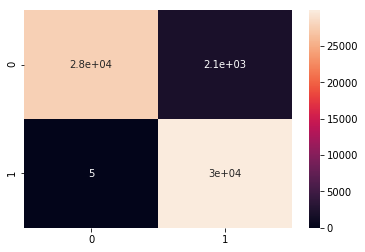

In [27]:
sn.heatmap(cm, annot=True)

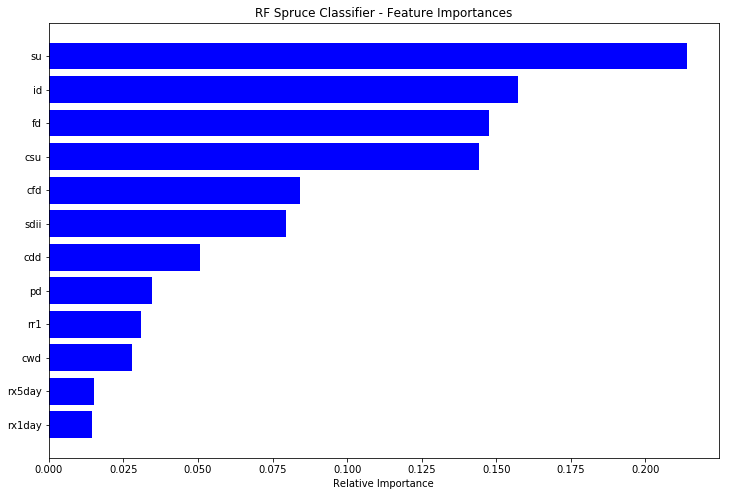

In [28]:
features = [c for c in X.columns]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('RF Spruce Classifier - Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()